# LightGBM Baseline Model

make models for each route(A, B, C, D) and prediction period(predict 2 weeks ahead, 4 weeks ahead, ...)

## Dateset
- [diff value from previous day](https://github.com/hiroshi-kuriyama/rail_level_gap/issues/2) of [rolling mean over days](https://github.com/hiroshi-kuriyama/rail_level_gap/issues/4)
## Target Variable
- vel_l values X weeks ahead (X = 2,4,6,8)
## Features

- track variables
  - present lev_l value
  - mean and variance of recent lev_l value
  - mean and variance of recent days and whole year values of track data
- equipment variables
  - row value of equipment variables
- seasonal variables
  - date (encoded by trigonometric function)
  - holiday dummy

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from hyperopt import hp, tpe, Trials, fmin
import optuna
%matplotlib inline
# from utils import data_process as dp

In [2]:
input_dir = '../input/'
working_dir = '../working/'
output_dir = '../output/'

## Read data

In [3]:
sleeper_type_dict = {
    1: 'pc',
    2: 'wooden',
    3: 'junction',
    4: 'short',
    5: 'synthetic',
    6: 'synth_junc',
    7: 'symth_short',
    8: 'other'
}

In [4]:
def read_track(line_name='a'):
    track_df = pd.read_csv(os.path.join(input_dir, 'track_{}.csv'.format(line_name.upper())))
    col_names_track = ['date', 'kilo', 'lev_l', 'lev_r', 'cur_l', 'cur_r', 'cant', 'width', 'speed']
    track_df.columns = col_names_track
    track_df['date'] = pd.to_datetime(track_df['date'])
    track_df['kilo'] = track_df['kilo'].astype('str')
    print('track_{line_name} shape: {shape}'.format(line_name=line_name.upper(), shape=track_df.shape))
    return track_df

In [5]:
def read_equ(line_name='a'):
    equ_df = pd.read_csv(os.path.join(input_dir, 'equipment_{}.csv'.format(line_name.upper())))
    col_names_equ = ['kilo', 'is_ballast', 'is_long', 'sleeper_type', 'is_bridge', 'is_crossing', 'gross_ton', 'radius', 'is_unreliable']
    equ_df.columns = col_names_equ
    equ_df['kilo'] = equ_df['kilo'].astype('str')
    equ_df['sleeper_type'] = equ_df['sleeper_type'].replace(sleeper_type_dict).astype('category')
    print('equ_{line_name} shape: {shape}'.format(line_name=line_name.upper(), shape=equ_df.shape))
    return equ_df

In [6]:
# degrade data types to save memory
def degrade_dtypes(df):
    for col in df.columns:
        if df[col].dtype=='int64':
            df[col] = df[col].astype('int32')
        if df[col].dtype=='float64':
            df[col] = df[col].astype('float32')
    return df

In [7]:
abcd = 'd'

In [8]:
track = read_track(abcd)
track = degrade_dtypes(track)
equ = read_equ(abcd)
equ = degrade_dtypes(equ)

track_D shape: (5601687, 9)
equ_D shape: (15691, 9)


In [9]:
# sample_submit = pd.read_csv(os.path.join(input_dir, 'sample_submit.csv'), header=None)
index_master = pd.read_csv(os.path.join(input_dir, 'index_master.csv'))
index_master.columns = ['id', 'line_name', 'date', 'kilo']
index_master['date'] = pd.to_datetime(index_master['date'])
index_master['kilo'] = index_master['kilo'].astype('str')

## Data Processing

In [10]:
# Drop outliers of diff to exclude maintenance effect (out of 2 sigma for each kilo)
# If line_name is "A", also drop outliers of lev_l
def outlier_filter(track):
    lev_pv = track.pivot(index='date', columns='kilo', values='lev_l')
    lev_pv.columns = lev_pv.columns.astype('str')
    lev_pv_diff = lev_pv.diff()

    lev_pv_diff_norm = (lev_pv_diff - lev_pv_diff.mean()) / lev_pv_diff.std()
    lev_pv_diff_norm_isnot_outlier = lev_pv_diff_norm.abs() < 2
    if abcd=='a':
        lev_pv_norm = (lev_pv - lev_pv.mean()) / lev_pv.std()
        lev_pv_norm_isnot_outlier = lev_pv_norm.abs() < 2
        lev_pv_diff_norm_isnot_outlier *= lev_pv_norm_isnot_outlier
    lev_pv_filtered_tmp = lev_pv * lev_pv_diff_norm_isnot_outlier
    lev_pv_filtered = lev_pv_filtered_tmp.replace(0.0, np.nan)
    lev_filtered = pd.melt(lev_pv_filtered.reset_index(), id_vars='date', value_name='lev_l')  
    track_new = lev_filtered.merge(track.drop('lev_l', axis=1), how='left', on=['date', 'kilo'])
    return track_new

In [11]:
track = outlier_filter(track)

/home/kuriyama/miniconda3/envs/rail_level_gap/lib/python3.6/site-packages/pandas/core/nanops.py:358: RuntimeWarning: divide by zero encountered in true_divide
  the_mean = the_sum / count


### rolling average, diff

In [12]:
# rolling average params
roll_params = {
    'A': {'window': 21, 'min_periods': 14},
    'B': {'window': 14, 'min_periods': 7},
    'C': {'window': 14, 'min_periods': 7},
    'D': {'window': 14, 'min_periods': 7}
}

In [13]:
def roll_pv(track, abcd):
    # pivot: row is date, col is kilo
    lev_pv = track.pivot(index='date', columns='kilo', values='lev_l')
    lev_pv.columns = lev_pv.columns.astype('str')
    # rolling average
    lev_pv_ra = lev_pv.rolling(**roll_params[abcd.upper()], center=False, axis=0).mean()
    return lev_pv_ra

In [14]:
lev_pv_ra = roll_pv(track, abcd)

In [15]:
# diff
lev_pv_ra_diff = lev_pv_ra.diff()
# reverse pivot
lev_ra_diff = pd.melt(lev_pv_ra_diff.reset_index(), id_vars='date', value_name='lev_l_diff')  

## Target variable

In [16]:
def make_tgt(lev_ra_diff):
    lev_ra_diff_tgt_tmp = lev_ra_diff.copy()
    lev_ra_diff_tgt_tmp['date_tgt'] = lev_ra_diff_tgt_tmp['date']
    lev_ra_diff_tgt_tmp['date'] = lev_ra_diff_tgt_tmp['date'] - datetime.timedelta(days=1)
    lev_ra_diff_tgt = lev_ra_diff_tgt_tmp.rename(columns={'lev_l_diff': 'lev_l_diff_tgt'})
    return lev_ra_diff_tgt

In [17]:
lev_ra_diff_tgt = make_tgt(lev_ra_diff)

## Feature processing

In [18]:
def whole_mean(track):
    track_whole_mean = track.groupby('kilo').mean()
    track_whole_mean.columns = [i + '_w_mean' for i in track_whole_mean.columns]
    track_whole_mean = track_whole_mean.reset_index()
    track_whole_mean['kilo'] = track_whole_mean['kilo'].astype(str)
    return track_whole_mean

In [19]:
def whole_std(track):
    track_whole_mean = track.groupby('kilo').std()
    track_whole_mean.columns = [i + '_w_std' for i in track_whole_mean.columns]
    track_whole_mean = track_whole_mean.reset_index()
    track_whole_mean['kilo'] = track_whole_mean['kilo'].astype(str)
    return track_whole_mean

In [20]:
track_whole_mean = whole_mean(track)
track_whole_std = whole_std(track)
track_diff_whole_mean = whole_mean(lev_ra_diff)
track_diff_whole_std = whole_std(lev_ra_diff)

## Merge Dataset

In [21]:
def make_day_cnts(df):
    # May is bitween hottest day and coldest one
    day_cnts = df['date'] - datetime.datetime(2017, 5, 1)
    return day_cnts.dt.days

In [22]:
def merge_features_by_kilo(df):
    df = df.merge(track_whole_mean, on='kilo')
    df = df.merge(track_whole_std, on='kilo')
    df = df.merge(track_diff_whole_mean, on='kilo')
    df = df.merge(track_diff_whole_std, on='kilo')
    df = df.merge(equ, on='kilo')
    return df

In [23]:
# copy target df
data_all_tmp = lev_ra_diff_tgt.copy()
# merge features
data_all_tmp = data_all_tmp.merge(lev_ra_diff, on=['date', 'kilo'])
data_all_tmp = data_all_tmp.merge(track[['date', 'kilo', 'lev_l']], on=['date', 'kilo'])

# seasonal featues (sin_date represents temperature)
data_all_tmp['sin_date'] = np.sin(2 * np.pi * make_day_cnts(data_all_tmp) / 365)

data_all_tmp = merge_features_by_kilo(data_all_tmp)

data_all_tmp = data_all_tmp.dropna(how='any', axis=0, subset=['lev_l_diff_tgt', 'lev_l_diff'])

data_all = data_all_tmp#.query('date<"2018-03-19"')
del data_all_tmp
# del lev_ra_diff_tgt, lev_ra_diff, track_whole_mean, data_all_tmp, track, equ

In [24]:
# keep the oreder of X columns
global data_all_col_order
data_all_col_order = data_all.columns

## Make Dataset

In [25]:
def X_y_split(data, tgt_col='lev_l_diff_tgt', index_cols=['date', 'date_tgt', 'kilo']):
    data = data.set_index(index_cols)
    y = data[tgt_col]
    X = data.drop(tgt_col, axis=1)
    return X, y

In [26]:
# split train and test
is_val = (make_day_cnts(data_all) % 8)==0
X_dev, y_dev = X_y_split(data_all[is_val==False])
X_val, y_val = X_y_split(data_all[is_val==True])

## Train

In [27]:
lgb_dev = lgb.Dataset(X_dev, y_dev)
lgb_val = lgb.Dataset(X_val, y_val)

In [28]:
fixed_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'l1',
    'verbose': 0,
    'seed': 0
}

In [29]:
def objective(trial):
    bagging_freq = trial.suggest_int('bagging_freq', 0, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.05, 1.0)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.75)
    min_child_samples = trial.suggest_int('min_child_samples', 300, 600)
    num_leaves = trial.suggest_int('num_leaves', 10, 500)
    
    opt_params = {
        'bagging_freq': bagging_freq,
        'feature_fraction': feature_fraction,
        'learning_rate': learning_rate,
        'min_child_samples': min_child_samples,
        'num_leaves': num_leaves
    }
    opt_params.update(fixed_params)
    
    model = lgb.train(opt_params, lgb_dev, num_boost_round=1000, valid_sets=lgb_val, early_stopping_rounds=30, verbose_eval=-1)
    y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    return mean_absolute_error(y_val, y_val_pred)

In [30]:
%%time
study = optuna.create_study()
study.optimize(objective, n_trials=50)

/home/kuriyama/miniconda3/envs/rail_level_gap/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[20]	valid_0's l1: 0.0272306


[I 2018-12-19 15:16:26,646] Finished a trial resulted in value: 0.02723062745652543. Current best value is 0.02723062745652543 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.24729809094818134, 'learning_rate': 0.5886064738403373, 'min_child_samples': 399, 'num_leaves': 143}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[7]	valid_0's l1: 0.0268942


[I 2018-12-19 15:16:31,467] Finished a trial resulted in value: 0.026894154370368156. Current best value is 0.026894154370368156 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.8334553160549991, 'learning_rate': 0.7163150930240174, 'min_child_samples': 311, 'num_leaves': 423}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[90]	valid_0's l1: 0.0267531


[I 2018-12-19 15:16:42,106] Finished a trial resulted in value: 0.026753130546845593. Current best value is 0.026753130546845593 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.7066401654563379, 'learning_rate': 0.10999708026402201, 'min_child_samples': 562, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[23]	valid_0's l1: 0.0267889


[I 2018-12-19 15:16:49,097] Finished a trial resulted in value: 0.026788864890684. Current best value is 0.026753130546845593 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.7066401654563379, 'learning_rate': 0.10999708026402201, 'min_child_samples': 562, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[42]	valid_0's l1: 0.0266562


[I 2018-12-19 15:16:55,095] Finished a trial resulted in value: 0.02665624843900033. Current best value is 0.02665624843900033 with parameters: {'bagging_freq': 0, 'feature_fraction': 0.5502579639161642, 'learning_rate': 0.4004377247880691, 'min_child_samples': 533, 'num_leaves': 110}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[18]	valid_0's l1: 0.0268283


[I 2018-12-19 15:17:00,031] Finished a trial resulted in value: 0.02682827477904939. Current best value is 0.02665624843900033 with parameters: {'bagging_freq': 0, 'feature_fraction': 0.5502579639161642, 'learning_rate': 0.4004377247880691, 'min_child_samples': 533, 'num_leaves': 110}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[46]	valid_0's l1: 0.0273021


[I 2018-12-19 15:17:04,515] Finished a trial resulted in value: 0.027302120102537807. Current best value is 0.02665624843900033 with parameters: {'bagging_freq': 0, 'feature_fraction': 0.5502579639161642, 'learning_rate': 0.4004377247880691, 'min_child_samples': 533, 'num_leaves': 110}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[55]	valid_0's l1: 0.0267052


[I 2018-12-19 15:17:14,133] Finished a trial resulted in value: 0.026705153213529707. Current best value is 0.02665624843900033 with parameters: {'bagging_freq': 0, 'feature_fraction': 0.5502579639161642, 'learning_rate': 0.4004377247880691, 'min_child_samples': 533, 'num_leaves': 110}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[75]	valid_0's l1: 0.0265675


[I 2018-12-19 15:17:23,113] Finished a trial resulted in value: 0.026567461793639117. Current best value is 0.026567461793639117 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.7652898761170185, 'learning_rate': 0.2571760759322818, 'min_child_samples': 301, 'num_leaves': 76}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[27]	valid_0's l1: 0.027244


[I 2018-12-19 15:17:28,018] Finished a trial resulted in value: 0.027244030809296015. Current best value is 0.026567461793639117 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.7652898761170185, 'learning_rate': 0.2571760759322818, 'min_child_samples': 301, 'num_leaves': 76}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[226]	valid_0's l1: 0.0265505


[I 2018-12-19 15:17:44,979] Finished a trial resulted in value: 0.02655045309529473. Current best value is 0.02655045309529473 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.5501812147747271, 'learning_rate': 0.22954353957845655, 'min_child_samples': 301, 'num_leaves': 15}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[269]	valid_0's l1: 0.0267977


[I 2018-12-19 15:18:24,283] Finished a trial resulted in value: 0.026797679210325772. Current best value is 0.02655045309529473 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.5501812147747271, 'learning_rate': 0.22954353957845655, 'min_child_samples': 301, 'num_leaves': 15}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[87]	valid_0's l1: 0.0266488


[I 2018-12-19 15:18:31,722] Finished a trial resulted in value: 0.026648757576219474. Current best value is 0.02655045309529473 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.5501812147747271, 'learning_rate': 0.22954353957845655, 'min_child_samples': 301, 'num_leaves': 15}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[135]	valid_0's l1: 0.0265268


[I 2018-12-19 15:18:42,636] Finished a trial resulted in value: 0.026526799225288465. Current best value is 0.026526799225288465 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.6306572812609922, 'learning_rate': 0.32460227035147415, 'min_child_samples': 591, 'num_leaves': 10}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[53]	valid_0's l1: 0.0266199


[I 2018-12-19 15:18:50,819] Finished a trial resulted in value: 0.02661987863790288. Current best value is 0.026526799225288465 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.6306572812609922, 'learning_rate': 0.32460227035147415, 'min_child_samples': 591, 'num_leaves': 10}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[20]	valid_0's l1: 0.0281729


[I 2018-12-19 15:18:54,300] Finished a trial resulted in value: 0.028172860609069542. Current best value is 0.026526799225288465 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.6306572812609922, 'learning_rate': 0.32460227035147415, 'min_child_samples': 591, 'num_leaves': 10}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[70]	valid_0's l1: 0.0268108


[I 2018-12-19 15:19:03,041] Finished a trial resulted in value: 0.026810765836895276. Current best value is 0.026526799225288465 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.6306572812609922, 'learning_rate': 0.32460227035147415, 'min_child_samples': 591, 'num_leaves': 10}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[91]	valid_0's l1: 0.0266211


[I 2018-12-19 15:19:14,353] Finished a trial resulted in value: 0.02662109988345987. Current best value is 0.026526799225288465 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.6306572812609922, 'learning_rate': 0.32460227035147415, 'min_child_samples': 591, 'num_leaves': 10}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[156]	valid_0's l1: 0.0266031


[I 2018-12-19 15:19:26,627] Finished a trial resulted in value: 0.026603095018341728. Current best value is 0.026526799225288465 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.6306572812609922, 'learning_rate': 0.32460227035147415, 'min_child_samples': 591, 'num_leaves': 10}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[207]	valid_0's l1: 0.0265837


[I 2018-12-19 15:19:42,212] Finished a trial resulted in value: 0.026583746794382877. Current best value is 0.026526799225288465 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.6306572812609922, 'learning_rate': 0.32460227035147415, 'min_child_samples': 591, 'num_leaves': 10}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[99]	valid_0's l1: 0.0266479


[I 2018-12-19 15:19:55,545] Finished a trial resulted in value: 0.026647880506692544. Current best value is 0.026526799225288465 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.6306572812609922, 'learning_rate': 0.32460227035147415, 'min_child_samples': 591, 'num_leaves': 10}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[21]	valid_0's l1: 0.0265077


[I 2018-12-19 15:20:01,366] Finished a trial resulted in value: 0.02650770073205761. Current best value is 0.02650770073205761 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9082687389306051, 'learning_rate': 0.4832910769130633, 'min_child_samples': 563, 'num_leaves': 180}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[21]	valid_0's l1: 0.0265516


[I 2018-12-19 15:20:06,914] Finished a trial resulted in value: 0.026551600238948692. Current best value is 0.02650770073205761 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9082687389306051, 'learning_rate': 0.4832910769130633, 'min_child_samples': 563, 'num_leaves': 180}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[32]	valid_0's l1: 0.0266421


[I 2018-12-19 15:20:13,476] Finished a trial resulted in value: 0.02664210295528477. Current best value is 0.02650770073205761 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9082687389306051, 'learning_rate': 0.4832910769130633, 'min_child_samples': 563, 'num_leaves': 180}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[19]	valid_0's l1: 0.0267357


[I 2018-12-19 15:20:19,657] Finished a trial resulted in value: 0.026735705638536753. Current best value is 0.02650770073205761 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9082687389306051, 'learning_rate': 0.4832910769130633, 'min_child_samples': 563, 'num_leaves': 180}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[22]	valid_0's l1: 0.0268408


[I 2018-12-19 15:20:25,306] Finished a trial resulted in value: 0.026840819126198002. Current best value is 0.02650770073205761 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9082687389306051, 'learning_rate': 0.4832910769130633, 'min_child_samples': 563, 'num_leaves': 180}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[21]	valid_0's l1: 0.0264798


[I 2018-12-19 15:20:30,140] Finished a trial resulted in value: 0.026479799862618194. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[6]	valid_0's l1: 0.026703


[I 2018-12-19 15:20:34,374] Finished a trial resulted in value: 0.0267029778477402. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[16]	valid_0's l1: 0.0267837


[I 2018-12-19 15:20:38,988] Finished a trial resulted in value: 0.02678373764764237. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[46]	valid_0's l1: 0.0272911


[I 2018-12-19 15:20:43,698] Finished a trial resulted in value: 0.02729108728576011. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[10]	valid_0's l1: 0.0268798


[I 2018-12-19 15:20:48,284] Finished a trial resulted in value: 0.026879760617686214. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[10]	valid_0's l1: 0.0268817


[I 2018-12-19 15:20:51,881] Finished a trial resulted in value: 0.02688166057929903. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[32]	valid_0's l1: 0.0268777


[I 2018-12-19 15:20:59,212] Finished a trial resulted in value: 0.026877746699763838. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[21]	valid_0's l1: 0.0266


[I 2018-12-19 15:21:05,000] Finished a trial resulted in value: 0.026600016332322254. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[9]	valid_0's l1: 0.0266256


[I 2018-12-19 15:21:09,383] Finished a trial resulted in value: 0.026625649908824406. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[10]	valid_0's l1: 0.0265744


[I 2018-12-19 15:21:13,547] Finished a trial resulted in value: 0.026574363920182774. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[43]	valid_0's l1: 0.026527


[I 2018-12-19 15:21:21,070] Finished a trial resulted in value: 0.026527006593021173. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[19]	valid_0's l1: 0.0265435


[I 2018-12-19 15:21:25,073] Finished a trial resulted in value: 0.02654353473441425. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[8]	valid_0's l1: 0.0270727


[I 2018-12-19 15:21:29,929] Finished a trial resulted in value: 0.027072667702248126. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[9]	valid_0's l1: 0.0266201


[I 2018-12-19 15:21:34,757] Finished a trial resulted in value: 0.026620138215569567. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[37]	valid_0's l1: 0.0271419


[I 2018-12-19 15:21:38,784] Finished a trial resulted in value: 0.02714185856681109. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[33]	valid_0's l1: 0.0265794


[I 2018-12-19 15:21:43,979] Finished a trial resulted in value: 0.02657941201772657. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[17]	valid_0's l1: 0.0267291


[I 2018-12-19 15:21:48,533] Finished a trial resulted in value: 0.02672905876999563. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[29]	valid_0's l1: 0.0265335


[I 2018-12-19 15:21:54,456] Finished a trial resulted in value: 0.026533460742302235. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[10]	valid_0's l1: 0.0266868


[I 2018-12-19 15:21:59,127] Finished a trial resulted in value: 0.026686776999891255. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[11]	valid_0's l1: 0.0267347


[I 2018-12-19 15:22:03,754] Finished a trial resulted in value: 0.026734652379629593. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[13]	valid_0's l1: 0.0268051


[I 2018-12-19 15:22:08,805] Finished a trial resulted in value: 0.026805092996693886. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[112]	valid_0's l1: 0.0268776


[I 2018-12-19 15:22:21,114] Finished a trial resulted in value: 0.02687757753750649. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[25]	valid_0's l1: 0.0267491


[I 2018-12-19 15:22:25,577] Finished a trial resulted in value: 0.026749096525652973. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[54]	valid_0's l1: 0.0266138


[I 2018-12-19 15:22:31,091] Finished a trial resulted in value: 0.026613772925136066. Current best value is 0.026479799862618194 with parameters: {'bagging_freq': 1, 'feature_fraction': 0.9349841440529534, 'learning_rate': 0.5660592763960708, 'min_child_samples': 491, 'num_leaves': 66}.


CPU times: user 36min 35s, sys: 14.9 s, total: 36min 50s
Wall time: 6min 8s


In [31]:
study.best_params

{'bagging_freq': 1,
 'feature_fraction': 0.9349841440529534,
 'learning_rate': 0.5660592763960708,
 'min_child_samples': 491,
 'num_leaves': 66}

In [32]:
best_params = study.best_params
best_params.update(fixed_params)
model = lgb.train(best_params, lgb_dev, valid_sets=lgb_val, early_stopping_rounds=30, verbose_eval=-1)

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[21]	valid_0's l1: 0.0264798


In [33]:
with open(os.path.join(output_dir, 'lgbm_baseline_20181219_model_{}.pkl'.format(abcd.upper())), mode='wb') as f:
    pickle.dump(model, f)
    
with open(os.path.join(output_dir, 'lgbm_baseline_20181219_model_{}.pkl'.format(abcd.upper())), mode='rb') as f:
    model = pickle.load(f)

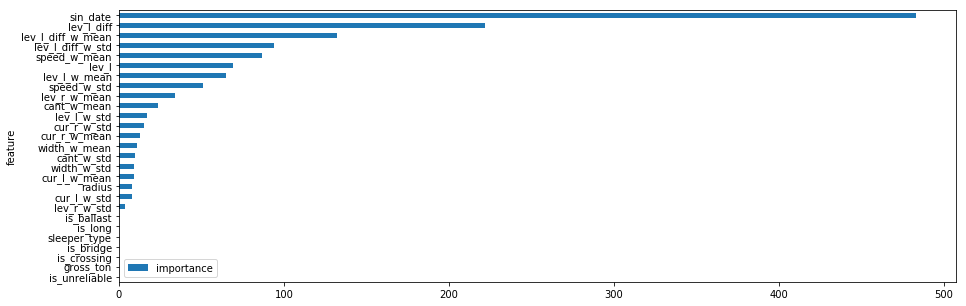

In [34]:
feature_importance = pd.DataFrame({'feature': X_dev.columns, 'importance': model.feature_importance()})
feature_importance = feature_importance.sort_values('importance').set_index('feature', drop=False)
ax = feature_importance.plot.barh(figsize=(15,5))

## Predict for Submission
1. make initial values using last date lev_l_diff of each kilo
2. predict 2 weeks ahead lev_l values by the initial values
3. predcit 4 weeks ahead lev_l values by the 2 weeks ahead lev_l values
4. repeat ...

### make initial values for future prediction

In [35]:
def make_last_date_pv(pv_df):
    last_date_pv_df = pv_df.fillna(method='ffill').tail(1)
    last_date_pv_df = last_date_pv_df.fillna(method='ffill', axis=1)
    return last_date_pv_df

def melt_pv(pv_df, value_name):
    return pd.melt(pv_df.reset_index(), id_vars='date', value_name=value_name)

### Repeat prediction and making datasets

In [36]:
# predict y
# y -> X_next_01
# X_next_01 -> y_next_02
# y_next_02-> X_next_02
# X_next_02 -> y_next_03 ...

In [37]:
def make_data_all_nxt(y_nxt, y_nxt_undiff):
    data_all_nxt = y_nxt.copy()
    data_all_nxt = data_all_nxt.merge(y_nxt_undiff, on=['date', 'kilo'], how='left')
    data_all_nxt['sin_date'] = np.sin(2 * np.pi * make_day_cnts(data_all_nxt) / 365)
    data_all_nxt = merge_features_by_kilo(data_all_nxt)
    data_all_nxt['date_tgt'] = data_all_nxt['date'] + datetime.timedelta(days=1)
    data_all_nxt['lev_l_diff_tgt'] = -1.0
    return data_all_nxt[data_all_col_order]

def make_y_nxt(data_all_current, model):
    X_current, y_ = X_y_split(data_all_current)
    y_nxt_np = model.predict(X_current)
    y_nxt = pd.Series(data=y_nxt_np, index=y_.index, name=y_.name)
#     y_nxt = y_nxt.rolling(5, min_periods=0, center=True).mean()
    y_nxt = y_nxt.reset_index(level=['date_tgt', 'kilo']).reset_index(drop=True)
    y_nxt = y_nxt.rename(columns={'date_tgt': 'date', 'lev_l_diff_tgt': 'lev_l_diff'})
    
    y_nxt_undiff = data_all_current[['date', 'kilo', 'lev_l']].copy()
    y_nxt_undiff['date'] = y_nxt_undiff['date'] + datetime.timedelta(days=1)
    y_nxt_undiff = y_nxt.merge(y_nxt_undiff, on=['date', 'kilo'], how='left')
    y_nxt_undiff['lev_l'] = y_nxt_undiff['lev_l'] + y_nxt_undiff['lev_l_diff']
    y_nxt_undiff = y_nxt_undiff[['date', 'kilo', 'lev_l']]
    return y_nxt, y_nxt_undiff

In [38]:
def predict4submission(lev_pv_ra_diff, lev_pv_ra, model):
    last_date_lev_ra_diff = melt_pv(make_last_date_pv(lev_pv_ra_diff), 'lev_l_diff')
    last_date_lev_ra = melt_pv(make_last_date_pv(lev_pv_ra), 'lev_l')
    last_date_lev_ra['lev_l'] = last_date_lev_ra['lev_l'] + last_date_lev_ra_diff['lev_l_diff']

    y_nxt_pool = y_nxt = last_date_lev_ra_diff
    y_nxt_undiff_pool = y_nxt_undiff = last_date_lev_ra
    for i in range(110): # more than 91days
        data_all_nxt = make_data_all_nxt(y_nxt, y_nxt_undiff)
        y_nxt, y_nxt_undiff = make_y_nxt(data_all_nxt, model)
        y_nxt_pool = pd.concat([y_nxt_pool, y_nxt], axis=0)
        y_nxt_undiff_pool = pd.concat([y_nxt_undiff_pool, y_nxt_undiff], axis=0)
    return y_nxt_undiff_pool

### Validation

In [39]:
y_nxt_undiff_pool_val = predict4submission(lev_pv_ra_diff.query('date<"2017-04-21"'), lev_pv_ra.query('date<"2017-04-21"'), model)
y_nxt_undiff_pool_val = y_nxt_undiff_pool_val.rename(columns={'lev_l': 'lev_l_pred'})

tru_pred_df = y_nxt_undiff_pool_val.merge(track, how='inner', on=['date', 'kilo'])
tru_pred_df = tru_pred_df[['date', 'kilo', 'lev_l', 'lev_l_pred']]
tru_pred_df = tru_pred_df.dropna()
print('sample: {:,}'.format(tru_pred_df.shape[0]))
print('MAE: {}'.format(mean_absolute_error(tru_pred_df['lev_l'], tru_pred_df['lev_l_pred'])))

sample: 997,518
MAE: 1.200000544498026


## Submission

In [40]:
y_nxt_undiff_pool = predict4submission(lev_pv_ra_diff.query('date<"2018-03-19"'), lev_pv_ra.query('date<"2018-03-19"'), model)
index_master_abcd = index_master.query('line_name=="{}"'.format(abcd.upper()))
pred_df = index_master_abcd.merge(y_nxt_undiff_pool, how='left', on=['date', 'kilo'])
pred_df = pred_df.rename(columns={'lev_l': 'lev_l_pred'})
pred_df = pred_df.drop('id', axis=1)

In [41]:
pred_df.to_csv(os.path.join(output_dir, 'lgbm_baseline_20181219_{}.csv'.format(abcd.upper())), index=False)

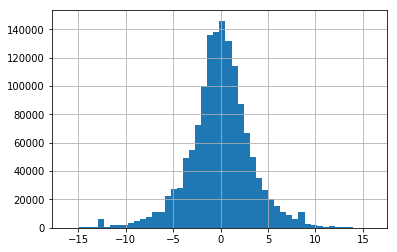

In [42]:
pred_df['lev_l_pred'].hist(bins=50)

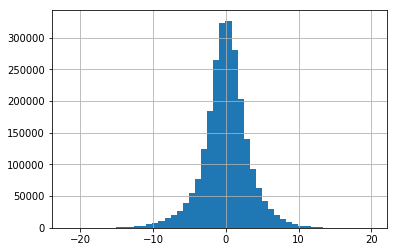

In [43]:
track['lev_l'].hist(bins=50)